In [4]:
%load_ext autoreload
%autoreload 1

# import segmentation_models_pytorch as smp
# from segmentation_models_pytorch.encoders import get_encoder

# from PIL import Image
import os
# from pathlib import Path
# import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as T

%aimport modules
from modules.DataScienceBowl import DataScienceBowl
from modules.Trainer import Trainer
from modules.CustomUnet import CustomUnet
from modules.Transforms import CombiTransform, ElasticTransform
from modules.denseCL import ProjectionModule, DenseContrastiveLoss, GlobalContrastiveLoss

from modules.denseCL.DenseCL import DenseCL

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Set device to GPU if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('using cuda')
else:
    device = torch.device('cpu')
    print('using cpu')
    

# Set seeds
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

using cuda


In [6]:
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
])

# Load data and split into train and test
dataset = DataScienceBowl('data/data_science_train', transform=transform)

indices = torch.randperm(len(dataset)).tolist()
N = len(indices)
# [ 0.3 train | 0.1 test | 0.1 validate | 0.5 unlab ]
# train_test, test_val, val_unlab = map(int, (0.3 * N, 0.4 * N, 0.5 * N))


# [ 0.2 train | 0.05 test | 0.05 validate | 0.5 unlab ]
train_test, test_val, val_unlab = map(int, (0.2 * N, 0.25 * N, 0.3 * N))


train_dataset = torch.utils.data.Subset(dataset, indices[:train_test])
test_dataset = torch.utils.data.Subset(dataset, indices[train_test:test_val])
val_dataset = torch.utils.data.Subset(dataset, indices[test_val:val_unlab])
unlabeled_dataset = torch.utils.data.Subset(dataset, indices[val_unlab:])

print(len(unlabeled_dataset))

BATCH_SIZE = 8
dataLoader_training = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dataLoader_test = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)
dataLoader_unlabeled = DataLoader(dataset=unlabeled_dataset, batch_size=BATCH_SIZE, shuffle=True)
dataLoader_validation = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)

469


In [7]:
MODEL_DIR = 'models/'
models/DenseCL_GRID_{dense_head}_E-{epoch+1}_LR-{lr}_LAM-{lam}.pt
MODEL_NAME = 'DenseCL_GRID_5x5_%s_of_50_epochs_lr%s.pt'

LR = str(0.001).replace('.', '_')
EPOCHS = list(map(str, range(4, 50, 5)))

print(DenseCL)

result_dict = dict()

for e in EPOCHS:
    MODEL_PATH = os.path.join(MODEL_DIR, MODEL_NAME %(e, LR))
    contrastive_model = DenseCL()
    contrastive_model.load_state_dict(torch.load(MODEL_PATH))
    
    unet = CustomUnet(contrastive_model.encoder).to(device)
    
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(unet.parameters(), lr=0.001)

    trainer = Trainer(model=unet,
                     device=device,
                     criterion=criterion,
                     optimizer=optimizer,
                     training_DataLoader=dataLoader_training,
                     validation_DataLoader=dataLoader_validation,
                     test_DataLoader=dataLoader_test,
                     epochs=20,
                     notebook=True,
                     seed=42)

    train_loss, val_loss, lr, test_loss, test_iou = trainer.run_trainer()
    
    result_dict[e] = {'train_loss': train_loss, 'val_loss': val_loss, 'lr':lr, 'test_loss':test_loss, 'test_iou':test_iou}
    

<class 'modules.denseCL.DenseCL.DenseCL'>
['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

['elastic', 'color', 'random', 'noise']


Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/17 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Test:   0%|          | 0/5 [00:00<?, ?it/s]

Test IoU 0.2478


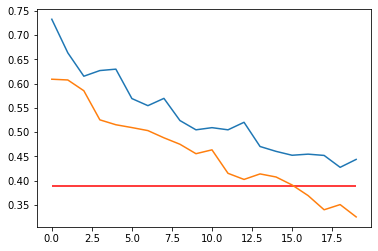

Test IoU 0.5054


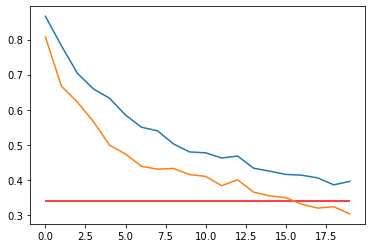

Test IoU 0.4823


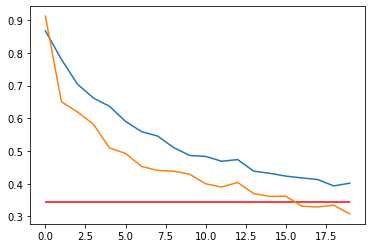

Test IoU 0.4471


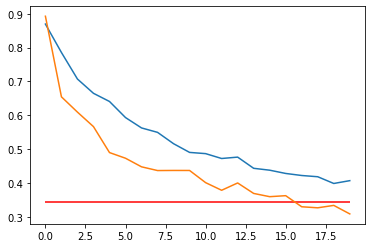

Test IoU 0.4444


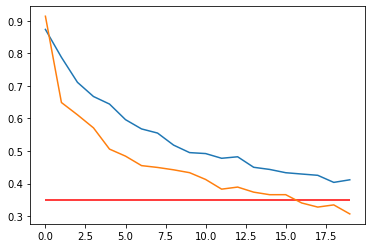

Test IoU 0.4618


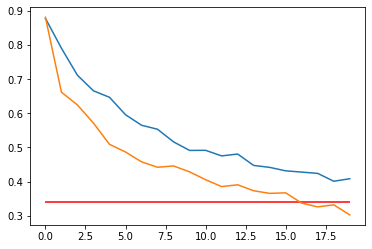

Test IoU 0.4668


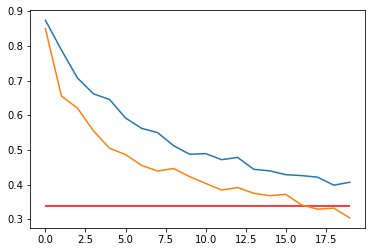

Test IoU 0.4498


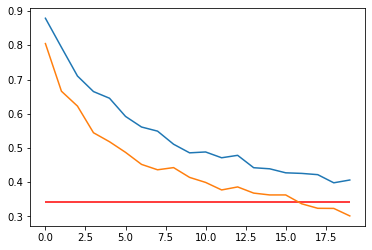

Test IoU 0.4406


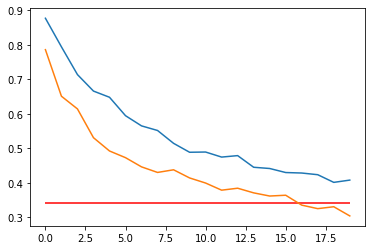

Test IoU 0.4307


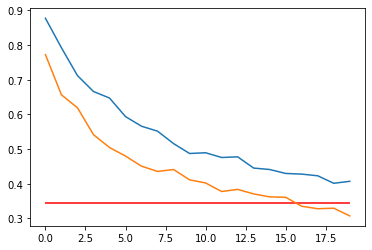

In [8]:
for e, results in result_dict.items():
    print('Test IoU', np.round(results['test_iou'], 4))
    plt.plot(results['train_loss'])
    plt.plot(results['val_loss'])
    plt.hlines(results['test_loss'], 0, len(results['train_loss']) - 1, color='red')
    plt.show()

In [21]:
import pickle


with open('results_lr0_01_analysis.pk', 'wb') as file:
    pickle.dump(result_dict, file)